In [11]:
%load_ext autoreload
%autoreload 2
import mkl
mkl.set_num_threads(1)

1

In [1]:
#%run ../../core/prepare_histograms.py
#%run ../../core/event_numbers.py

# Imports

In [2]:
import pickle

from matplotlib.lines import Line2D
from tools import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import InterpolatedUnivariateSpline, RegularGridInterpolator
from aeff_calculations import calc_aeff_factor
from fluxes import *
from tools import get_mids

from tqdm import tqdm

import healpy as hp
from aeff_calculations import setup_aeff_grid, earth_rotation
from aeff_calculations import aeff_eval_e_sd
import settings as st

/home/hpc/capn/capn102h/miniconda3/envs/plenum/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Point-source binning!


# calculate event numbers assuming point-like sources

In [3]:
print("Calculate detection efficiencies")
# both files have the same information, but the 'MH' file contains Mephistograms instead of arrays
if True:
    with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
        aeff_2d = pickle.load(f)
else:
    with open(join(BASEPATH, f"resources/effective_area_upgoing.pckl"), "rb") as f:
        aeff_2d = pickle.load(f)


Calculate detection efficiencies


In [4]:

### calculate raw neutrino rate ~ detection efficiency
# Res = integral dE ( A_eff * (E/GeV)**(-gamma) ) / delta sindec
gamma_range = [2.0, 2.5, 3.0]  # np.round(np.arange(1.5, 3.6, step=0.1), decimals=1)
## NEW: base on PS acceptance


# compare ps and diffuse acceptances

In [5]:

_res = []
det = "IceCube"
flux = PL_flux(PHI_NGC, 2.0, E0_NGC, "powerlaw")
for dec in get_mids(st.dec_bins):
    src_config = dict(
        sindec_mids=st.sindec_mids,
        livetime=LIVETIME,
        ewidth=st.ewidth,
        dpsi_max=0,
        grid_2d=1,
        diff_or_ps="ps",
        dec=dec,
    )

    aeff_factor_signal = calc_aeff_factor(aeff_2d[det], **src_config)

    k_s = astro_flux(
        aeff_factor_signal,
        st.emids,
        energy_resolution=None,
        phi_scaling=1,
        flux_shape=flux,
    )
    _res.append(np.sum(k_s))
_res = np.array(_res)

In [6]:
Res = np.sum(
    aeff_eval_e_sd(
        aeff_2d["IceCube"], np.ones_like(st.sindec_width), st.ewidth, st.ra_width
    )
    * PHI_ASTRO * LIVETIME * (emids / E_NORM) ** (-2),
    axis=-1,
)

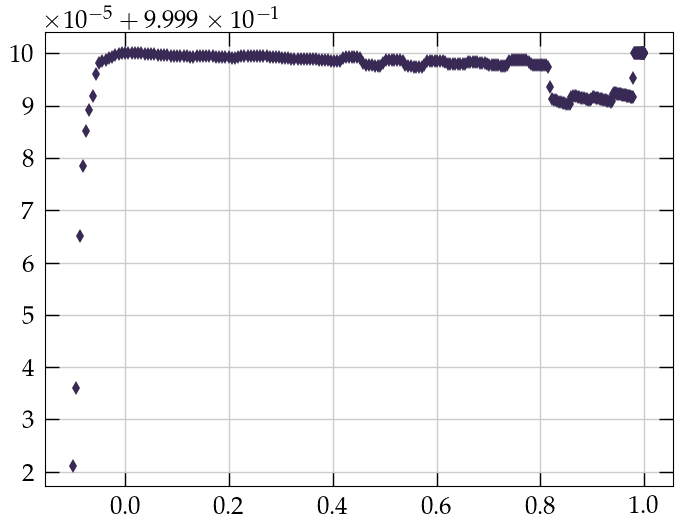

In [7]:
# plt.plot(np.exp(tcks[2]["IceCube"](_sindec_mids)))
# plt.plot(st.sindec_mids, _res/np.max(_res), "o")
# plt.plot(st.sindec_mids, Res/np.max(Res), "s")
plt.plot(st.sindec_mids, _res/np.max(_res) / (Res/np.max(Res)), "d")
# plt.yscale("log")

# calculate detection efficiency based on PS flux

In [8]:
tcks = dict()
for ii, gamma in enumerate(gamma_range):
    flux = PL_flux(PHI_NGC, gamma, E0_NGC, "powerlaw")
    tcks[gamma] = dict()
    for det in poles:
        if "Plenum" in det:
            continue
        _res = []
        for dec in get_mids(st.dec_bins):
            src_config = dict(
                sindec_mids=st.sindec_mids,
                livetime=LIVETIME,
                ewidth=st.ewidth,
                dpsi_max=0,
                grid_2d=1,
                diff_or_ps="ps",
                dec=dec,
            )

            aeff_factor_signal = calc_aeff_factor(aeff_2d[det], **src_config)

            k_s = astro_flux(
                aeff_factor_signal,
                st.emids,
                energy_resolution=None,
                phi_scaling=1,
                flux_shape=flux,
            )
            _res.append(np.sum(k_s))
        _res = np.array(_res)

#         #log_res = np.where(_res > 0, np.log(_res), -10 * np.ones_like(_res))
        tcks[gamma][det] = InterpolatedUnivariateSpline(st.sindec_mids, _res)

with open(join(LOCALPATH, "detection_efficiencies.pckl"), "wb") as f:
    pickle.dump((tcks, st.sindec_mids), f)

In [9]:
sns.set_palette("magma", n_colors=11)

In [10]:
# baseline resolution
with open(join(LOCALPATH, "energy_smearing_GP_up.pckl"), "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

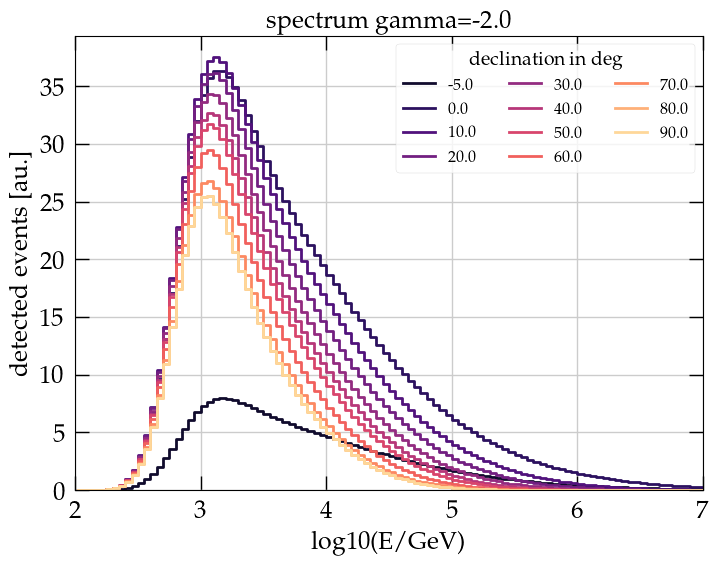

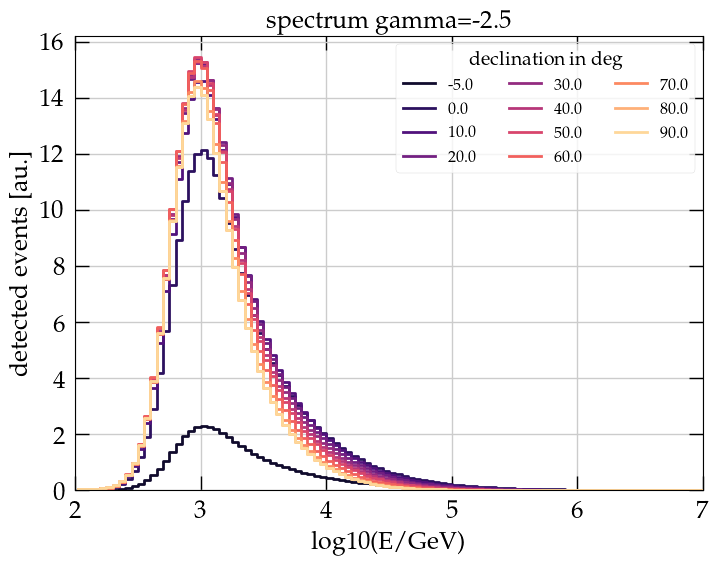

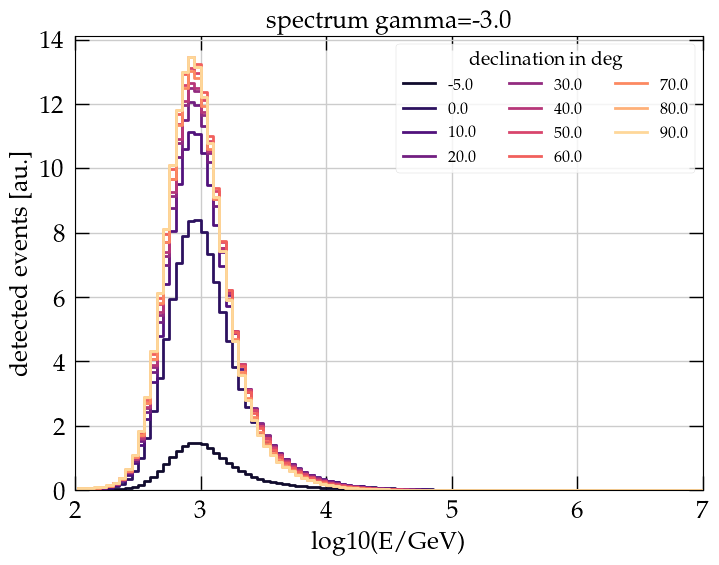

In [14]:
_decs = np.linspace(0, np.pi/2, num=10, endpoint=True)
_decs = np.concatenate([[np.deg2rad(-5)], _decs])
for ii, gamma in enumerate(gamma_range):
    flux = PL_flux(PHI_NGC, gamma, E0_NGC, "powerlaw")
    det = "IceCube"
    for dec in _decs:
        src_config = dict(
            sindec_mids=st.sindec_mids,
            livetime=LIVETIME,
            ewidth=st.ewidth,
            dpsi_max=0,
            grid_2d=1,
            diff_or_ps="ps",
            dec=dec,
        )

        aeff_factor_signal = calc_aeff_factor(aeff_2d[det], **src_config)

        k_s = astro_flux(
            aeff_factor_signal,
            st.emids,
            energy_resolution=baseline_eres,
            phi_scaling=1,
            flux_shape=flux,
        )
        plt.figure(1+ii)
        plt.plot(st.logE_reco_mids, k_s, label=f"{np.rad2deg(dec):1.1f}", ds="steps-mid")
    plt.legend(ncol=3, fontsize="small", title="declination in deg")
    # plt.yscale("log")
    plt.ylim(0, None)
    plt.xlim(2, 7)
    plt.xlabel("log10(E/GeV)")
    plt.ylabel("detected events [au.]")
    plt.title(f"spectrum gamma=-{gamma}")
    # break

(0.0, 6.222217495496592)

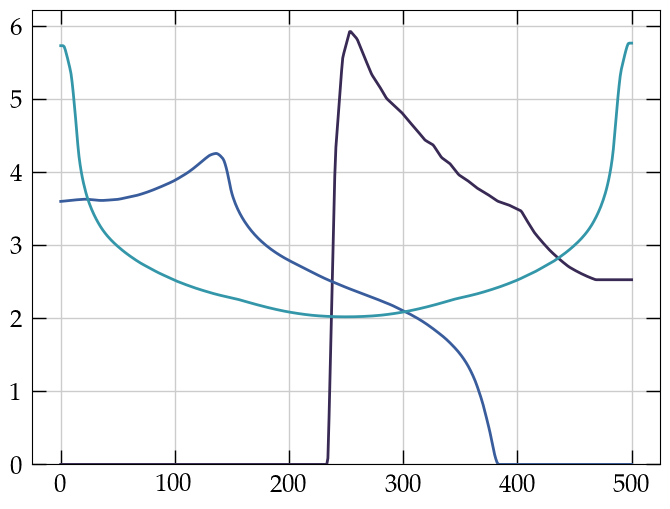

In [55]:
plt.plot(tcks[2.0]["IceCube"](st.sindec_mids))
plt.plot(tcks[2.0]["P-ONE"](st.sindec_mids))
plt.plot(tcks[2.0]["Horizon"](st.sindec_mids))
plt.ylim(0, None)

# instantaneous 2D detection efficiencies

In [ ]:
print("Calculate instantaneous detection efficiencies")
# same, but instantaneous, i.e. time/RA dependence
num = 500
# ra_vals = np.linspace(0, 2 * np.pi, num, endpoint=True)
# ra_val_mids = get_mids(ra_vals)
# ra_val_width = np.diff(ra_vals)
# dec_vals = np.arcsin(np.linspace(-1, 1, num, endpoint=True))
# dec_vals = np.linspace(-np.pi / 2, np.pi / 2, num)
# dec_val_mids = get_mids(dec_vals)

inst_rel_events_ra_dec = {}
rel_events_ra_dec = {}

nside = 2**8
npix = hp.nside2npix(nside)
pix = np.arange(npix)
hp_angles = hp.pix2ang(nside, pix)

# binning setup
_azi = hp_angles[1]
_zen = hp_angles[0] - np.pi / 2

# for rotation
hp_coords = SkyCoord(_azi * u.radian, _zen * u.radian, frame="icrs")

# for integration
pp, tt = np.meshgrid(st.ra_mids, np.arcsin(st.sindec_mids))
eq_coords = SkyCoord(pp * u.radian, tt * u.radian, frame="icrs")


for ii, gamma in tqdm(enumerate(gamma_range)):
    inst_rel_events_ra_dec[gamma] = {}
    rel_events_ra_dec[gamma] = {}

    rel_tmp = tcks[gamma]["IceCube"](st.sindec_mids)

    grid2d, _ = setup_aeff_grid(
        [rel_tmp],
        st.sindec_mids,
        st.ra_mids,
        st.ra_width,
        local=True,
        log_int=False,
    )

    for k, coord in poles.items():
        if "Plenum" in k:
            continue
        new_aeff = earth_rotation(
            poles[k]["lat"],
            poles[k]["lon"],
            eq_coords,
            hp_coords,
            grid2d,
            ra_width,
            log_aeff=False,
            return_3D=True,
            time=Time("2025-01-01 00:00:00"),
        )
        inst_rel_events_ra_dec[gamma][k] = new_aeff[0] / np.max(new_aeff)

with open(join(LOCALPATH, "inst_rel_events_ra_dec.pckl"), "wb") as f:
    pickle.dump((inst_rel_events_ra_dec, st.ra_mids, np.arcsin(st.sindec_mids)), f)

Calculate instantaneous detection efficiencies


3it [00:08,  2.93s/it]


# check visuals

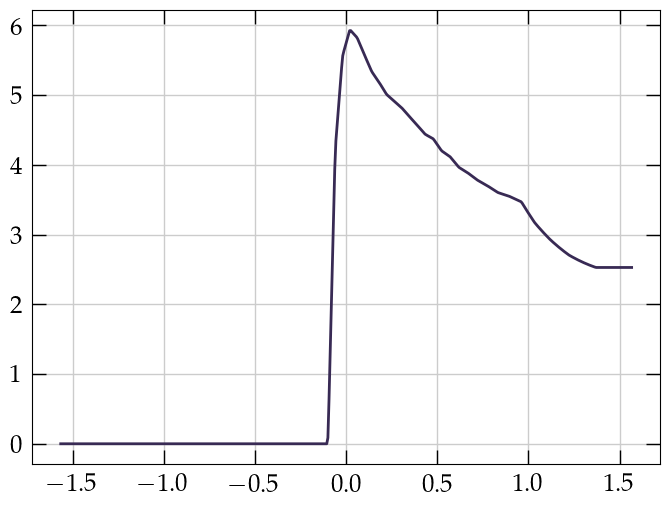

In [71]:
plt.plot(np.arcsin(st.sindec_mids), tcks[gamma]["IceCube"](st.sindec_mids))

In [97]:
with open(join(LOCALPATH, "inst_rel_events_ra_dec.pckl"), "rb") as f:
    rel_events, ra_vals, dec_vals = pickle.load(f)


In [101]:
np.shape(rel_events[2]["IceCube"]), np.shape(inst_rel_events_ra_dec[2]["IceCube"]), np.shape(new_aeff[0])

((501, 499), (501, 499), (501, 499))

In [103]:
len(st.ra_mids), len(st.sindec_mids), len(ra_vals), len(dec_vals)

(499, 501, 499, 501)

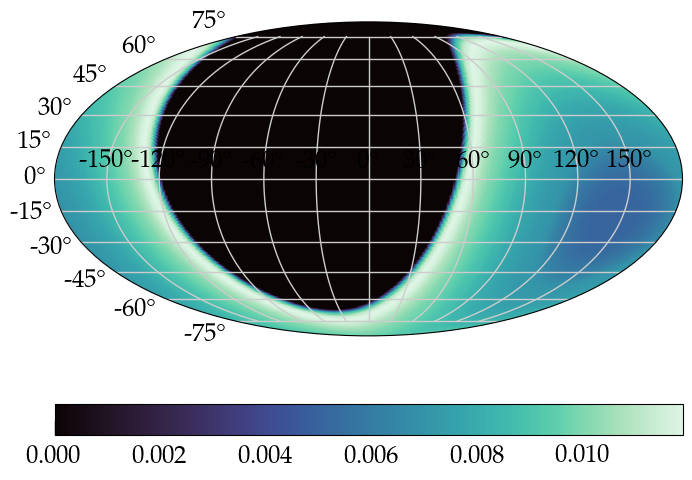

In [104]:
f, ax = plt.subplots(subplot_kw=dict(projection="mollweide"))
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    new_aeff[0],
    vmin=0,
    linewidth=0,
    rasterized=True,
    zorder=0.2
)
plt.colorbar(p, orientation="horizontal")

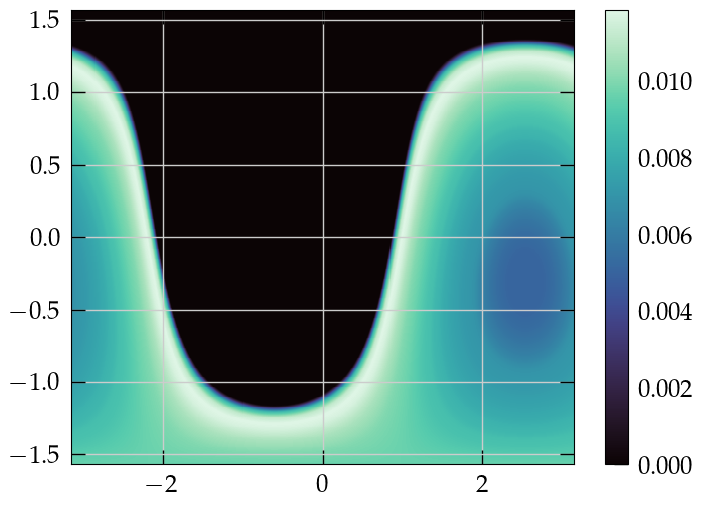

In [105]:
plt.pcolormesh(
    st.ra_mids - np.pi, #np.pi - ra_vals
    np.arcsin(st.sindec_mids),
    new_aeff[0],
    vmin=0,
    linewidth=0,
    rasterized=True,
    zorder=0.2
)
plt.colorbar()

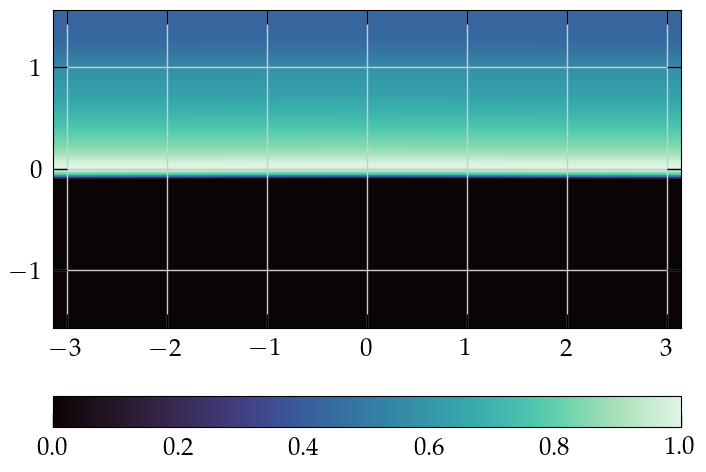

In [106]:
plt.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events[2]["IceCube"],
    vmin=0,
    linewidth=0,
    rasterized=True,
    zorder=0.2
)
plt.colorbar(orientation="horizontal")

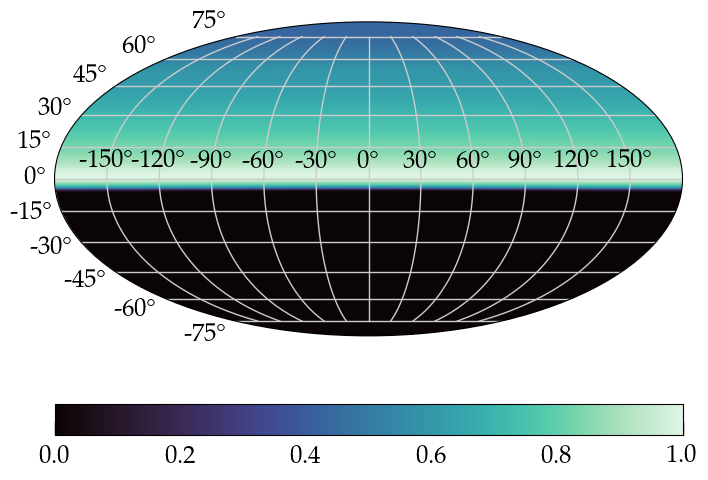

In [107]:
f, ax = plt.subplots(subplot_kw=dict(projection="mollweide"))
p = ax.pcolormesh(
    ra_vals - np.pi, #np.pi - ra_vals
    dec_vals,
    rel_events[2]["IceCube"],
    vmin=0,
    linewidth=0,
    rasterized=True,
    zorder=0.2
)
plt.colorbar(p, orientation="horizontal")

# visualize rotation per day 
(in the right direction, as seen in equatorial coordinates, which is a bit counter-intuitive)

In [15]:
from aeff_calculations import earth_rotation

In [16]:
num = 500
ra_vals = np.linspace(0, 2 * np.pi, num, endpoint=True)
ra_val_mids = get_mids(ra_vals)
ra_val_width = np.diff(ra_vals)
dec_vals = np.arcsin(np.linspace(-1, 1, num, endpoint=True))
# dec_vals = np.linspace(-np.pi / 2, np.pi / 2, num)
dec_val_mids = get_mids(dec_vals)

inst_rel_events_ra_dec = {}
rel_events_ra_dec = {}

nside = 2**8
npix = hp.nside2npix(nside)
pix = np.arange(npix)
hp_angles = hp.pix2ang(nside, pix)

# binning setup
_azi = hp_angles[1]
_zen = hp_angles[0] - np.pi / 2

# for rotation
hp_coords = SkyCoord(_azi * u.radian, _zen * u.radian, frame="icrs")

# for integration
pp, tt = np.meshgrid(st.ra_mids, np.arcsin(st.sindec_mids))
eq_coords = SkyCoord(pp * u.radian, tt * u.radian, frame="icrs")



In [18]:
with open(join(LOCALPATH, "detection_efficiencies.pckl"), "rb") as f:
    tcks, _ = pickle.load(f)

In [45]:
poles["KM3NeT"]["lon"].value / 360 * 24

1.0733333333333335

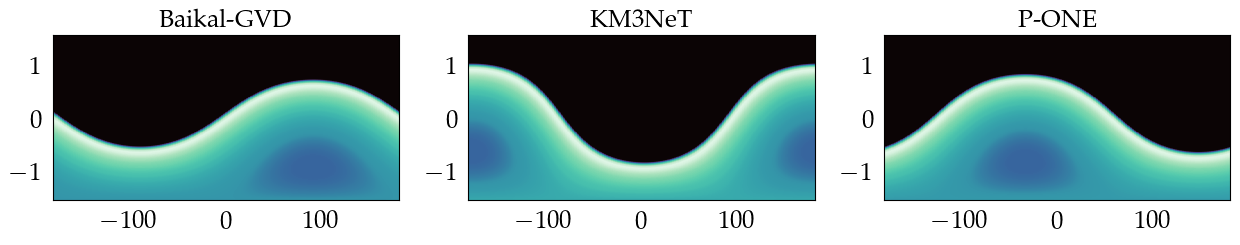

In [61]:
gamma = 2.0

rel_tmp = tcks[gamma]["IceCube"](st.sindec_mids)

grid2d, _ = setup_aeff_grid(
    [rel_tmp],
    st.sindec_mids,
    st.ra_mids,
    st.ra_width,
    local=True,
    log_int=False,
)
k = "KM3NeT"
time = Time("2025-01-01 04:00:00")
dt = Time("2025-01-01 12:00:00") - Time("2025-01-01 11:00:00")  # 1 hour
for i in range(3):
    f, axes = plt.subplots(
        figsize=(15, 2), ncols=3#, subplot_kw=dict(projection="mollweide")
    )
    for ii, k in enumerate(["Baikal-GVD", "KM3NeT", "P-ONE"]):
        new_aeff = earth_rotation(
            poles[k]["lat"],
            poles[k]["lon"],
            eq_coords,
            hp_coords,
            grid2d,
            ra_width,
            log_aeff=False,
            return_3D=True,
            time=time + i * 2 * dt,
        )
        _inst = new_aeff[0] / np.max(new_aeff)
        axes[ii].pcolormesh(
            np.rad2deg(st.ra_mids - np.pi),
            np.arcsin(st.sindec_mids),
            _inst,
            linewidth=0,
            rasterized=True,
        )
        axes[ii].set_title(k)
    plt.show()
    break

In [20]:
np.shape(inst_km3net)

(501, 499)

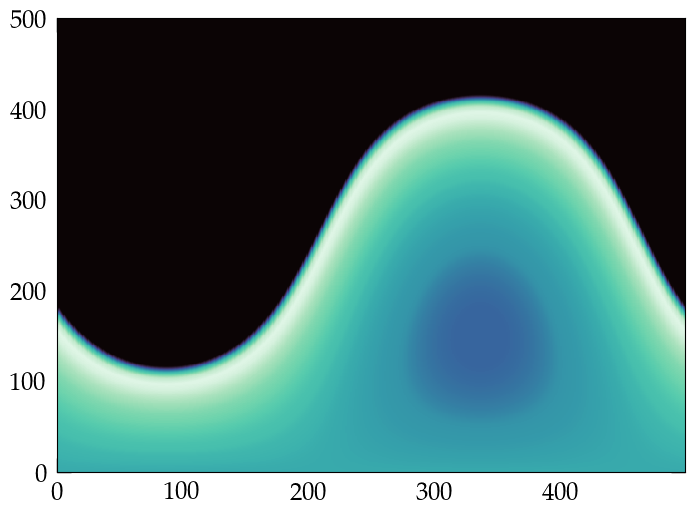

In [21]:
plt.pcolormesh(inst_km3net)

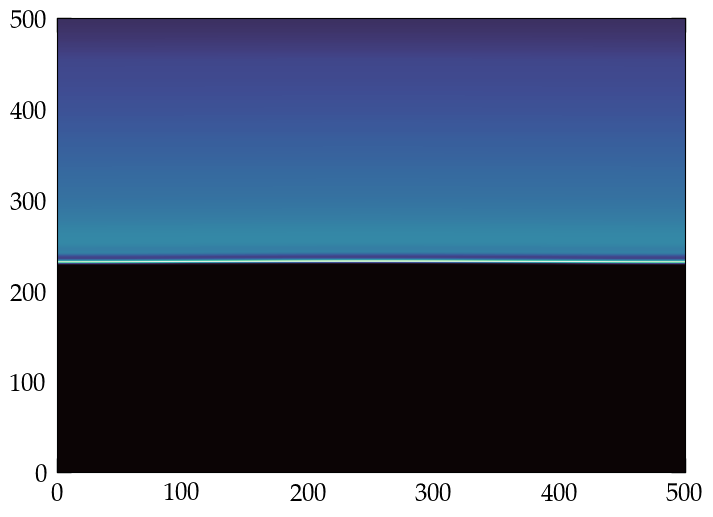

In [15]:
plt.pcolormesh(inst_rel_events_ra_dec[2]["IceCube"])

# coordinates

In [4]:
### colorful
if True:
    poles["IceCube"]["color"] = "k"
    poles["P-ONE"]["color"] = "#a50000"
    poles["KM3NeT"]["color"] = colors[1] #"#a50000"
    poles["Baikal-GVD"]["color"] = "purple"
else:
    ### p-one highlight
    poles["IceCube"]["color"] = "k"
    poles["P-ONE"]["color"] = "#a50000"
    poles["KM3NeT"]["color"] = colors[0]
    poles["Baikal-GVD"]["color"] = colors[2]

## get all detection efficiencies $\propto N_{detected}$ per fixed livetime

In [5]:
with open(join(LOCALPATH, "detection_efficiencies.pckl"), "rb") as f:
    tcks, padded_sd = pickle.load(f)


## IceCube only

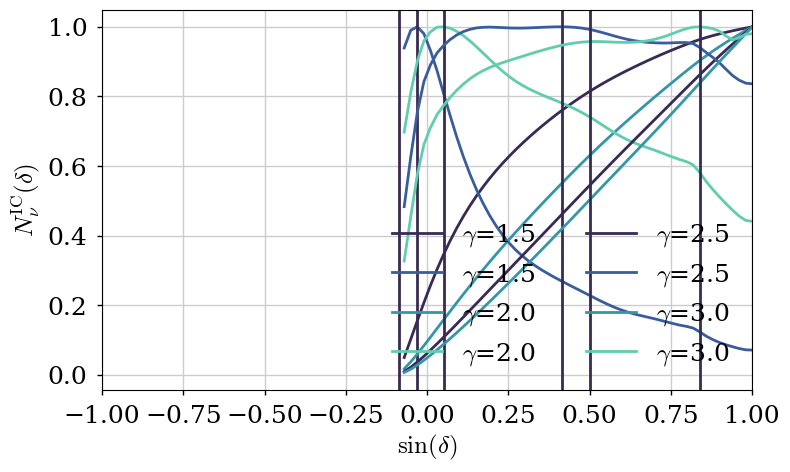

In [6]:
sindec_vals = np.linspace(-1, 1, 100)
gammas = [1.5, 2.0, 2.5, 3.0]
fig, ax = plt.subplots()
for gamma in gammas:
    eff = np.exp(tcks[gamma]["IceCube"](sindec_vals)) * LIVETIME * PHI_0
    mask = sindec_vals >= np.sin(np.deg2rad(-5))
    p = ax.plot(sindec_vals[mask], np.cumsum(eff[mask]) / np.sum(eff[mask]), label=r"$\gamma$={0:.1f}".format(gamma))
    p = ax.plot(sindec_vals[mask], eff[mask] / np.max(eff[mask]), label=r"$\gamma$={0:.1f}".format(gamma))
    ax.axvline(sindec_vals[mask][np.argmax(eff[mask])])

ax.legend(ncol=2, frameon=False, loc=4)
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(r"$N_{\nu}^{\rm IC}(\delta)$")

ax.set_xlim(-1, 1)

ax.axvline(np.sin(np.deg2rad(-5)))
ax.axvline(np.sin(np.deg2rad(30)))

fig.tight_layout()
plt.subplots_adjust(top=0.85)
# if False:
#     ax.set_yscale("log")
# else:
#     #plt.ylim(10, 30)
#     #plt.xlim(-0.2, 0.55)


## all detectors
equal contribution, detection efficiency relative to icecube at respective declination

1.5
PLENUM-1 Improv at GC: 6.31231088753793
PLENUM-1 Improv at txs0506: 2.461844718161991
PLENUM-1 Improv at ngc1068: 2.001214889103848

PLENUM-2 Improv at GC: 12.812326756176535
PLENUM-2 Improv at txs0506: 8.961837420138952
PLENUM-2 Improv at ngc1068: 8.501237129153951
- - - - - - - - - - 
2.0
PLENUM-1 Improv at GC: 28.641333032414572
PLENUM-1 Improv at txs0506: 2.3798340407961467
PLENUM-1 Improv at ngc1068: 2.43919584066394

PLENUM-2 Improv at GC: 35.1413492233732
PLENUM-2 Improv at txs0506: 8.879833758477542
PLENUM-2 Improv at ngc1068: 8.939191895841581
- - - - - - - - - - 
2.5
PLENUM-1 Improv at GC: 286.55003289518766
PLENUM-1 Improv at txs0506: 2.5143091040057146
PLENUM-1 Improv at ngc1068: 2.8157401213227025

PLENUM-2 Improv at GC: 293.05003684108374
PLENUM-2 Improv at txs0506: 9.014310730989388
PLENUM-2 Improv at ngc1068: 9.315767855306067
- - - - - - - - - - 
3.0
PLENUM-1 Improv at GC: 4097.95809216187
PLENUM-1 Improv at txs0506: 2.6391732504455034
PLENUM-1 Improv at ngc1068: 3

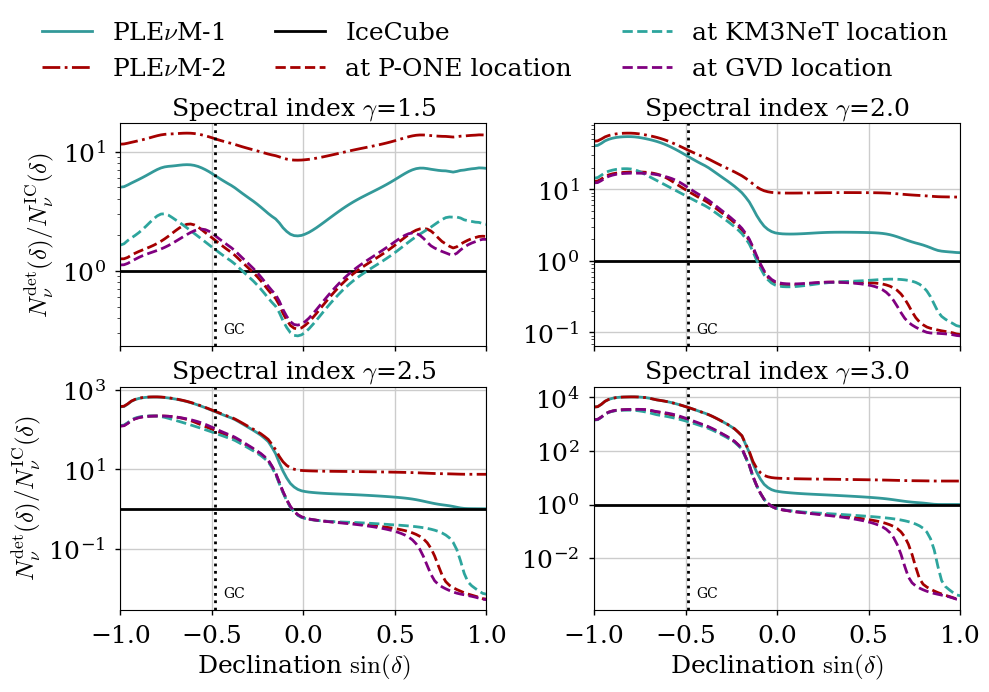

In [7]:
sindec_vals = np.linspace(-1, 1, 100)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 7))
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    for det in tcks[gamma]:
        if "Gen" in det:
            continue
        Res = np.exp(tcks[gamma][det](sindec_vals)) / np.exp(
            tcks[gamma]["IceCube"](sindec_vals)
        )
        p = ax.plot(
            sindec_vals,
            Res,
            label=poles[det]["label"] if ii == 0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2,
        )
    ax.set_title(
        r"Spectral index $\gamma$={0:.1f}".format(gamma)
    )
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    # ax.axvline(np.sin(txs0506.icrs.dec), color="k", ls=":")
    ax.set_yscale("log")
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes)
    # calculate the improvement with PLEnuM relative to IceCube
    if True:
        print(gamma)
        improv_sgr = np.exp(tcks[gamma]["Plenum-1"](np.sin(sgr_a.icrs.dec))) / np.exp(
            tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec))
        )
        improv_txs0506 = np.exp(
            tcks[gamma]["Plenum-1"](np.sin(txs0506.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(txs0506.icrs.dec)))
        improv_ngc1068 = np.exp(
            tcks[gamma]["Plenum-1"](np.sin(ngc1068.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(ngc1068.icrs.dec)))
        print("PLENUM-1 Improv at GC:", improv_sgr)
        print("PLENUM-1 Improv at txs0506:", improv_txs0506)
        print("PLENUM-1 Improv at ngc1068:", improv_ngc1068)
        print("")

        improv_sgr = np.exp(tcks[gamma]["Plenum-2"](np.sin(sgr_a.icrs.dec))) / np.exp(
            tcks[gamma]["IceCube"](np.sin(sgr_a.icrs.dec))
        )
        improv_txs0506 = np.exp(
            tcks[gamma]["Plenum-2"](np.sin(txs0506.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(txs0506.icrs.dec)))
        improv_ngc1068 = np.exp(
            tcks[gamma]["Plenum-2"](np.sin(ngc1068.icrs.dec))
        ) / np.exp(tcks[gamma]["IceCube"](np.sin(ngc1068.icrs.dec)))
        print("PLENUM-2 Improv at GC:", improv_sgr)
        print("PLENUM-2 Improv at txs0506:", improv_txs0506)
        print("PLENUM-2 Improv at ngc1068:", improv_ngc1068)
        print("- "*10)

axes[2].set_xlabel(r"Declination $\sin(\delta)$")
axes[3].set_xlabel(r"Declination $\sin(\delta)$")
axes[0].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$")
axes[2].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$")
fig.legend(loc="upper center", ncol=3, frameon=False)
fig.tight_layout()
plt.subplots_adjust(top=0.82)
fig.savefig(join(BASEPATH, "plots/relative_detection_eff_dIC_vs_sindec.pdf"))


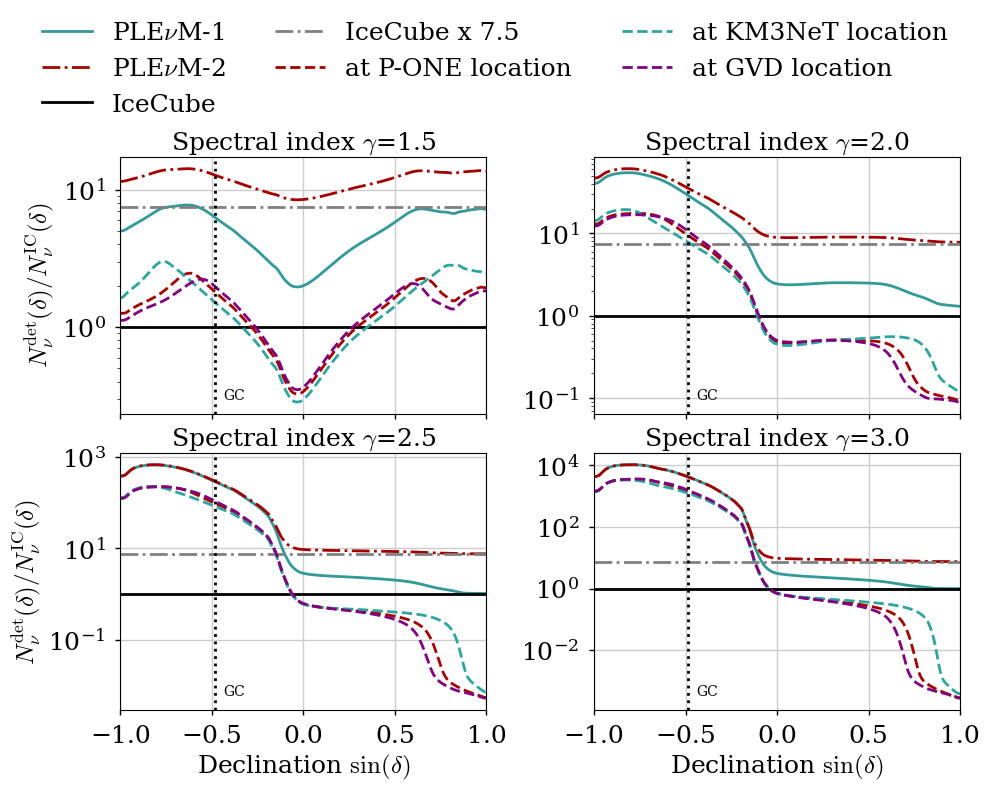

In [8]:
sindec_vals = np.linspace(-1, 1, 1000)

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 8))
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    for det in tcks[gamma]:
        Res = np.exp(tcks[gamma][det](sindec_vals)) / np.exp(
            tcks[gamma]["IceCube"](sindec_vals)
        )
        p = ax.plot(
            sindec_vals,
            Res,
            label=poles[det]["label"] if ii == 0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2,
        )
    ax.set_title(r"Spectral index $\gamma$={0:.1f}".format(gamma))
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    # ax.axvline(np.sin(txs0506.icrs.dec), color="k", ls=":")
    ax.set_yscale("log")
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes)


axes[2].set_xlabel(r"Declination $\sin(\delta)$")
axes[3].set_xlabel(r"Declination $\sin(\delta)$")
axes[0].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$")
axes[2].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$")
fig.legend(loc="upper center", ncol=3, frameon=False)
fig.tight_layout()
plt.subplots_adjust(top=0.8)
fig.savefig(join(BASEPATH, "plots/relative_detection_eff_dIC_vs_sindec_wGen2.pdf"))


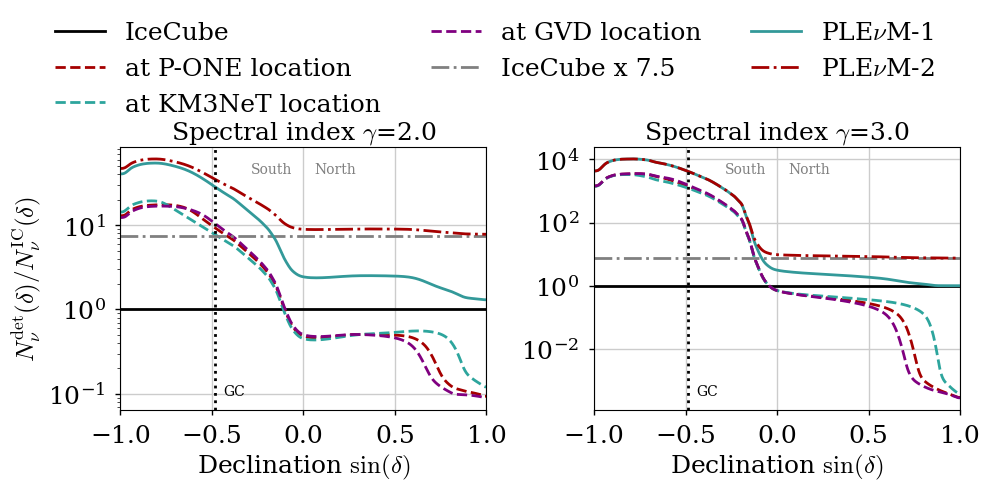

In [9]:
sindec_vals = np.linspace(-1, 1, 1000)

fig, axes = plt.subplots(ncols=2, sharex=True, figsize=(10, 5))
axes = axes.flatten()
for ii, gamma in enumerate([2.0, 3.0]):
    ax = axes[ii]
    for det in [
        "IceCube",
        "P-ONE",
        "KM3NeT",
        "Baikal-GVD",
        "Gen-2",
        "Plenum-1",
        "Plenum-2",
    ]:
        Res = np.exp(tcks[gamma][det](sindec_vals)) / np.exp(
            tcks[gamma]["IceCube"](sindec_vals)
        )
        p = ax.plot(
            sindec_vals,
            Res,
            label=poles[det]["label"] if ii == 0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2,
        )
    ax.set_title(r"Spectral index $\gamma$={0:.1f}".format(gamma))
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    # ax.axvline(np.sin(txs0506.icrs.dec), color="k", ls=":")
    ax.set_yscale("log")
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes)
    ax.text(
        0.47,
        0.9,
        "South",
        transform=ax.transAxes,
        color="gray",
        ha="right",
    )
    ax.text(
        0.53,
        0.9,
        "North",
        transform=ax.transAxes,
        color="gray",
        ha="left",
    )

axes[0].set_xlabel(r"Declination $\sin(\delta)$")
axes[1].set_xlabel(r"Declination $\sin(\delta)$")
axes[0].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta)$")
fig.legend(loc="upper center", ncol=3, frameon=False)
fig.tight_layout()
plt.subplots_adjust(top=0.7)
fig.savefig(join(BASEPATH, "relative_detection_eff_dIC_vs_sindec_wGen2_smaller.pdf"))


## improvement for specific sources

In [10]:
print(txs0506, ngc1068)
gamma_txs0506 = 2
n_txs0506 = 5.4
gamma_ngc1068 = 3.2
n_ngc1068 = 79 #50.4


<SkyCoord (ICRS): (ra, dec) in deg
    (77.36, 5.69)> <SkyCoord (ICRS): (ra, dec) in deg
    (40.67, -0.01)>


In [11]:
improv_txs0506_1 = np.exp(
    tcks[gamma_txs0506]["Plenum-1"](np.sin(txs0506.icrs.dec))
) / np.exp(tcks[gamma_txs0506]["IceCube"](np.sin(txs0506.icrs.dec)))
improv_txs0506_2 = np.exp(
    tcks[gamma_txs0506]["Plenum-2"](np.sin(txs0506.icrs.dec))
) / np.exp(tcks[gamma_txs0506]["IceCube"](np.sin(txs0506.icrs.dec)))
print(
    "txs0506 in icecube: n=",
    n_txs0506,
    "gamma=",
    gamma_txs0506,
)
print(
    "txs0506 in plenum-1: n=",
    improv_txs0506_1 * n_txs0506,
    f"({improv_txs0506_1})",
    ", txs0506 in plenum-2: n=",
    improv_txs0506_2 * n_txs0506,
    f"({improv_txs0506_2})",
)

improv_ngc1068_1 = np.exp(
    tcks[gamma_ngc1068]["Plenum-1"](np.sin(ngc1068.icrs.dec))
) / np.exp(tcks[gamma_ngc1068]["IceCube"](np.sin(ngc1068.icrs.dec)))
improv_ngc1068_2 = np.exp(
    tcks[gamma_ngc1068]["Plenum-2"](np.sin(ngc1068.icrs.dec))
) / np.exp(tcks[gamma_ngc1068]["IceCube"](np.sin(ngc1068.icrs.dec)))
print(
    "ngc1068 in icecube: n=",
    n_ngc1068,
    "gamma=",
    gamma_ngc1068,
)
print(
    
    "ngc1068 in plenum-1: n=",
    improv_ngc1068_1 * n_ngc1068,
    f"({improv_ngc1068_1})",
    ", ngc1068 in plenum-2: n=",
    improv_ngc1068_2 * n_ngc1068,
    f"({improv_ngc1068_2})",
)


txs0506 in icecube: n= 5.4 gamma= 2
txs0506 in plenum-1: n= 12.851103820299192 (2.3798340407961467) , txs0506 in plenum-2: n= 47.95110229577873 (8.879833758477542)
ngc1068 in icecube: n= 79 gamma= 3.2
ngc1068 in plenum-1: n= 254.63597601442532 (3.2232402027142446) , ngc1068 in plenum-2: n= 768.1422085745817 (9.72331909588078)


## all detectors 
detection efficiency 1D (sin dec) relative to icecube at horizon

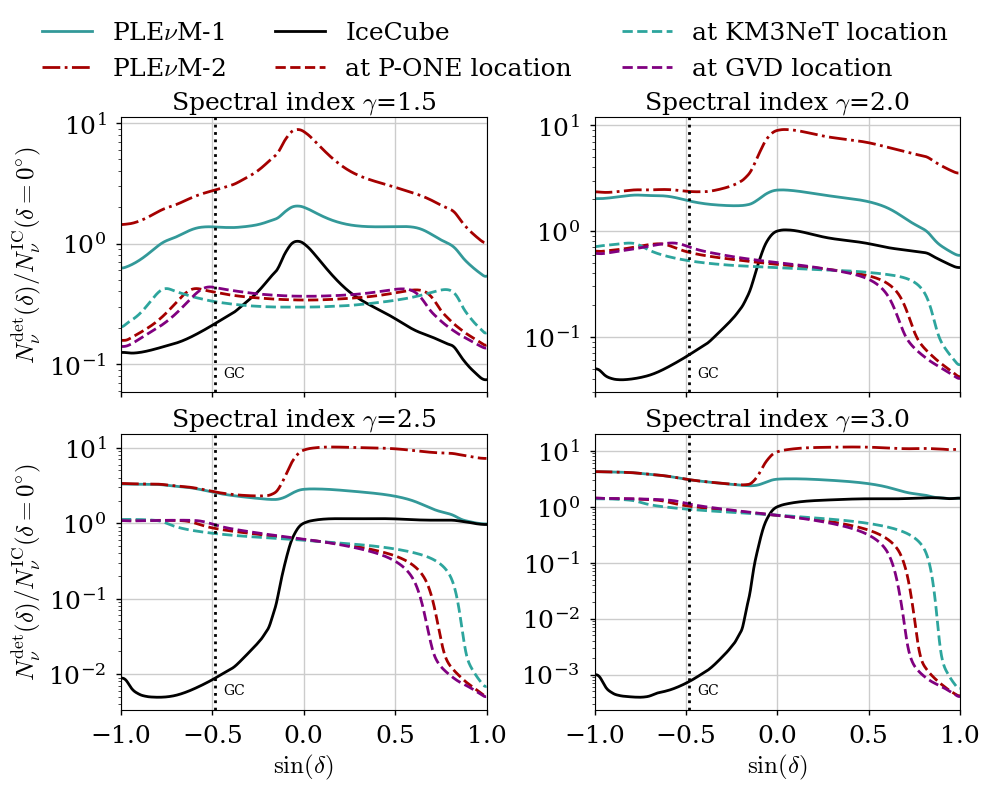

In [12]:
gammas = [1.5, 2.0, 2.5, 3.0]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 8))
axes = axes.flatten()
for ii, gamma in enumerate(gammas):
    ax = axes[ii]
    # detection efficiency of IceCube for specific spectral index at the horizon
    ## NOTE: maximum detection efficiency changes with spectral index, so we fix this to the horizon here
    arb_max_ic = np.exp(tcks[gamma]["IceCube"](0))
    for det in tcks[gamma]:
        if "Gen" in det:
            continue
        Res = np.exp(tcks[gamma][det](sindec_vals)) / arb_max_ic
        p = ax.plot(
            sindec_vals,
            Res,
            label=poles[det]["label"] if ii == 0 else "",
            color=poles[det]["color"],
            ls=poles[det]["ls"],
            lw=2,
        )
    ax.set_title(r"Spectral index $\gamma$={0:.1f}".format(gamma))
    ax.axvline(np.sin(sgr_a.icrs.dec), color="k", ls=":")
    # ax.axvline(np.sin(txs0506.icrs.dec), color="k", ls=":")
    ax.set_yscale("log")
    ax.set_xlim(-1, 1)
    ax.text(0.28, 0.055, "GC", transform=ax.transAxes)

axes[2].set_xlabel(r"$\sin(\delta)$")
axes[3].set_xlabel(r"$\sin(\delta)$")
axes[0].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta=0^{\circ})$")
axes[2].set_ylabel(r"$N_{\nu}^{\rm det}(\delta) / N_{\nu}^{\rm IC}(\delta=0^{\circ})$")
fig.legend(
    loc="upper center",
    ncol=3,
    frameon=False,
)
fig.tight_layout()
plt.subplots_adjust(top=0.85)
fig.savefig(join(BASEPATH, "plots/relative_detection_eff_d0_vs_sindec.pdf"))
